# Day1: **1:1 문의 내용 기반 문의유형 자동 분류 모델링**

* [미션0] 오늘의 목표
* [미션1] 개발환경 설정하기
* [미션2] 데이터 전처리하기
* [미션3] 단어사전 만들기
* [미션4] 모델 학습 데이터 생성
* [미션5] 모델 생성하기
* [미션6] 분류 모델 고도화
* <도전미션> 테스트 데이터를 활용한 모델 성능 뽐내기

----------

### <span style="color:green;background-color:#fff5b1"> [미션0] 오늘의 목표: </span><span style="color:red;background-color:#fff5b1">1:1 문의 자동분류 모델링</span>

* 1:1 문의 분석팀에는 AIVLE 1:1 문의의 답변을 위해 문의 내용을 일일이 확인하여 분야별 담당 전문 튜터에게 전달해야 합니다.
* 그러나 수많은 1:1 문의를 읽고 분야를 나누는 일은 많은 리소스와 시간이 필요 합니다.
* 특히 최근 일반 문의가 코드 문의에 섞여 들어오는 일이 점점 증가 하고 있습니다.
* 코드문의와 일반문의를 자동으로 구별할 수 있는 자연어 처리 딥러닝 모델을 생성하고 테스트 데이터를 통해 모델을 고도화 해주세요.




### <span style="color:green;background-color:#fff5b1">[미션1] 개발환경 설정하기</span>

1:1 문의 자동 분류기를 만들기 위하여 필요한 라이브러리와 데이터를 불러 옵니다.
* 필요 라이브러리를 호출하기
* 데이터 파일 불러오기
* 불필요 컬럼 삭제하기
* '\n'(줄바꿈문자 또는 개행문자) 삭제하기


In [2]:
# 필요 라이브러리를 호출하기
## 필요한 라이브러리는 추가로 불러 오세요.
## 프로젝트를 진행하며 필요한 라이브러리는 추가로 설치 하세요.

import pandas as pd    # pandas 데이터프레임을 생성/편집하기 위해 사용 합니다.
import numpy as np    # numpy 행렬을 생성/편집하기 위해 사용 합니다.
# import os    # 시스템에 접근하기 위해 사용 합니다.
# import joblib    # 오브젝트를 파일로 저장하기 위해 사용 합니다.

from tqdm import tqdm   # 실행되고 있는 셀의 진행 상황을 보기 위해 사용 합니다.
from collections import Counter    # 단어의 수를 카운트하기 위해 사용 합니다.
import re    # 정규표현식을 사용하기 위해 사용 합니다.
# from konlpy.tag import Okt # 문장을 형태소 단위로 분리하기 위해 사용합니다.

from sklearn.model_selection import train_test_split    # 학습할 데이터를 나눌때 사용 합니다.
# from sklearn.preprocessing import OneHotEncoder    # 컬럼의 고유한 값에 따라 1과 0으로 열을 생성해 줍니다.

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer    # 문장을 단어로 나누어 줍니다.
from tensorflow.keras.preprocessing.sequence import pad_sequences    # 지정한 칸만큼  빈 공간을 0으로 채워 줍니다.

from tensorflow.keras.models import Sequential    # # 딥러닝 인공신경망을 생성하는데 사용합니다.
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN  # 인공신경망의 기능별 레이어를 구성하는데 사용합니다.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint    # 모델 학습 시 자원절약을 위해 사용됩니다.


from sklearn.metrics import confusion_matrix    # 모델의 예측결과를 효율적으로 표현해 줍니다.
from sklearn.metrics import classification_report    # 모델의 결과를 각 지표에 따라 보여 줍니다.

import matplotlib.pyplot as plt    # 데이터를 각종 차트로 시각화하기 위해 사용 합니다.
import seaborn as sns    # 데이터를 각종 차트로 시각화하기 위해 사용 합니다.

font_path = 'malgun.ttf' # 워드클라우드 한글 폰트 사용


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [14]:
# 데이터 파일 불러오기
## 'QnA_train_data.csv' 파일 불러와 data 변수에 할당 합니다.

data = pd.read_csv('QnA_train_data.csv')
data.head()

,트랙,지역,문의내용,문의유형
0,DX컨설턴트,수도권,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2
1,AI개발자,수도권,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영
2,AI개발자,전남/전북,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..?\n맞다면, 질문드립니...",시스템 운영
3,DX컨설턴트,충남/충북,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1
4,DX컨설턴트,대구/경북,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여\n운전을 못하는 관광객 ...,이론


In [15]:
# 불필요 컬럼 삭제하기
## drop 함수를 사용하여 필요없는 컬럼을 삭제 합니다.
## 삭제할 컬럼: ['트랙', '지역']

data = data.drop(columns=['트랙', '지역'], axis=1)
data.head()

,문의내용,문의유형
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..?\n맞다면, 질문드립니...",시스템 운영
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여\n운전을 못하는 관광객 ...,이론


In [16]:
# '\n'(줄바꿈문자 또는 개행문자) 삭제하기
## 줄바꿈문자는 워드클라우드에서 에러를 일으켜 삭제 해야 합니다.
## 반복문을 사용하여 data['문의내용']의 각 열에서 '\n'을 ' '으로 변경 한 후
## 다시 data['문의내용']에 넣어 줍니다.

for i in range(len(data)):
    data['문의내용'][i] = data['문의내용'][i].replace('\n', ' ')

data.head()

,문의내용,문의유형
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",시스템 운영
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,이론


### <span style="color:green;background-color:#fff5b1"> [미션2] 데이터 전처리하기</span>

자연어 처리는 일반 데이터에 비해 많은 자원과 시간을 사용합니다.
많은 시간과 자원을 절약하고 모델의 성능을 높이기 위해서 특수문자 제거, 불용어 제거 등 특별한 데이터 클렌징을 시행 합니다.
데이터 클렌징에 정해진 방법은 없습니다.
코드셀의 설명을 따라 최고의 성능을 낼 수 있도록 데이터 클렌징(전처리)를 시행해 주세요.

* 특수문자 제거하기
* 단어 분리하기
* 불용어 제거하기
* 한글자 단어 제거하기
* 문의 길이(단어 개수) 측정하기
* 문의별 단어의 수 시각화하기
* 문의별 단어의 수(cleansing_length) 기초통계량 확인하기
* 문의 길이(단어 개수) 상한선 정하기

In [13]:
# [실행코드] 특수문자 제거 함수 실행
## 아래의 함수 생성 코드를 실행해 주세요
## 아래의 특수문자 이외의 특수문제 제거가 필요한 경우 자유롭게 추가하여 사용하세요.

removal_list =  "‘, ’, ◇, ‘, ”,  ’, ', ·, \“, ·, △, ●,  , ■, (, ), \", >>, `, /, #, ∼, =,ㆍ<,>, .,?, !,【,】, …, ◆,%, ₩"
def remove_special(sentence: str = None):

    sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^ㄱ-ㅎ가-힣a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)
    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()
    sentence = sentence.replace('\n', ' ')

    return sentence

# [실행코드] 특수문자를 제거하는 함수

In [19]:
# 특수문자 제거하기
## data['문의내용'] 각 행에서 특수 문제를 제거 후 결과를 담을 data['특수문자제거'] 빈 열을 생성 합니다.
## remove_special 함수를 사용하여 data['문의내용']의 각 행에서 특수문자를 제거하고 data['특수문자제거'] 열에 결과를 할당해 주세요.
data['특수문자제거'] = ''

for i in range(len(data)):
    data['특수문자제거'][i] = remove_special(data['문의내용'][i])

data.head()

,문의내용,문의유형,특수문자제거
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2,inplace True 를 사용하는 기준이 존재하는 것인지 아니면 함수나 메소드에 ...
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영,참조파일 에 대한 yolo부분 답안 파일이 올라오지 않은 것 같습니다
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",시스템 운영,AICE 시험 관련하여 이렇게 대 로 질문하는게 맞나요 맞다면 질문드립니다 구글링이...
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1,예제는 잘 작동한 것 같은데 채점하니 케이스 만 성공하고 나머지가 fail이 떠 실...
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,이론,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...


In [20]:
# 단어 분리하기
## data['특수문자제거'] 각 행의 문장을 단어의 모음으로 분리 한 결과를 담을 data['단어분리'] 빈 열을 생성 합니다.
## data['특수문자제거']의 각 행의 문장을 띄어쓰기(' ') 기준으로 split 하여 같은 행의 data['단어분리'] 열에 할당 합니다.
## [참고] 딥러닝 시간에 배운 KoNLPy 라이브러리의 Okt 형태소 분석기를 사용해도 됩니다.
data['단어분리'] = ''

for i in range(len(data)):
    data['단어분리'][i] = data['특수문자제거'][i].split(' ')

data.head()


,문의내용,문의유형,특수문자제거,단어분리
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2,inplace True 를 사용하는 기준이 존재하는 것인지 아니면 함수나 메소드에 ...,"[inplace, True, 를, 사용하는, 기준이, 존재하는, 것인지, 아니면, ..."
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영,참조파일 에 대한 yolo부분 답안 파일이 올라오지 않은 것 같습니다,"[참조파일, 에, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]"
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",시스템 운영,AICE 시험 관련하여 이렇게 대 로 질문하는게 맞나요 맞다면 질문드립니다 구글링이...,"[AICE, 시험, 관련하여, 이렇게, 대, 로, 질문하는게, 맞나요, 맞다면, 질..."
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1,예제는 잘 작동한 것 같은데 채점하니 케이스 만 성공하고 나머지가 fail이 떠 실...,"[예제는, 잘, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가..."
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,이론,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,"[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ..."


In [21]:
# [실행코드] 조사, 인사말, 불용어 제거 함수 실행
## 아래의 함수 생성 코드를 실행해 주세요
## 아래의 불용어 이외의 불용어 제거가 필요한 경우 자유롭게 추가하여 사용하세요. 

def remove_stopword(sent):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자','에','와','한','이', '로', '에서', '하는', '하면', '하고', '요', '혹시', '합니다', '감사합니다', '안녕하세요']
    removed = [word for word in sent if not word in stopwords] # 불용어 제거
    return removed

# [실행코드] 조사, 인사말, 불용어를 제거하는 함수

In [22]:
# 불용어 제거하기하기
## 자연어를 예측할 때 데이터에 조사, 접속사, 감탄사, 인사말 등이 포함되면 불필요한 자원 및 시간을 사용 할 수 있습니다.
## 불필요한 자원사용 방지를 위해 데이터에서 불용어를 제거해 줍니다.
## data['단어분리'] 에서 불용어를 제한 한 뒤 결과를 담을 data['불용어제거'] 열을 생성해 줍니다.
## remove_stopword 함수를 사용하여 data['단어분리']에서 불용어를 제거하고 결과를 data['불용어제거'] 열에 할당 합니다.
## 모델의 정확도 향상을 위해 제거하고 싶은 불용어가 있을 경우 remove_stopword 함수의 stopwords 변수에 추가해 주세요.

data['불용어제거'] = ''

for i in range(len(data)):
    data['불용어제거'][i] = remove_stopword(data['단어분리'][i])

data.head()


,문의내용,문의유형,특수문자제거,단어분리,불용어제거
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2,inplace True 를 사용하는 기준이 존재하는 것인지 아니면 함수나 메소드에 ...,"[inplace, True, 를, 사용하는, 기준이, 존재하는, 것인지, 아니면, ...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나..."
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영,참조파일 에 대한 yolo부분 답안 파일이 올라오지 않은 것 같습니다,"[참조파일, 에, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]"
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",시스템 운영,AICE 시험 관련하여 이렇게 대 로 질문하는게 맞나요 맞다면 질문드립니다 구글링이...,"[AICE, 시험, 관련하여, 이렇게, 대, 로, 질문하는게, 맞나요, 맞다면, 질...","[AICE, 시험, 관련하여, 이렇게, 대, 질문하는게, 맞나요, 맞다면, 질문드립..."
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1,예제는 잘 작동한 것 같은데 채점하니 케이스 만 성공하고 나머지가 fail이 떠 실...,"[예제는, 잘, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가...","[예제는, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가, f..."
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,이론,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,"[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ..."


In [26]:
# 한글자 단어 제거하기
## 한글자 단어는 단어의 중요도에 비해 빈도수가 너무 높아 모델 정확도 향상에 방해가 될 수 있습니다.
## data['불용어제거'] 에 각 행에서 한글자 단어를 제거 후 결과를 담을 data['한글자제거'] 빈 열을 추가 합니다.
## 각 행마다 한글자 단어를 제거후 남은 단어들을 담을 data['한글자제거'] 열을 생성 합니다.
## 반복문을 사용하여 data['불용어제거'] 의 각 행에서 단어 추출하고 단어의 글자수(len)을 측정하여 2글자 이상인 단어만 data['한글자제거'] 열에 할당해 줍니다.

data['한글자제거'] = ''

for i in range(len(data)):
    temp = []
    for j in data['불용어제거'][i]:
        if len(j) > 1:
            temp.append(j)
    data['한글자제거'][i] = temp
    
data.head()


,문의내용,문의유형,특수문자제거,단어분리,불용어제거,한글자제거
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2,inplace True 를 사용하는 기준이 존재하는 것인지 아니면 함수나 메소드에 ...,"[inplace, True, 를, 사용하는, 기준이, 존재하는, 것인지, 아니면, ...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나..."
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영,참조파일 에 대한 yolo부분 답안 파일이 올라오지 않은 것 같습니다,"[참조파일, 에, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 같습니다]"
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",시스템 운영,AICE 시험 관련하여 이렇게 대 로 질문하는게 맞나요 맞다면 질문드립니다 구글링이...,"[AICE, 시험, 관련하여, 이렇게, 대, 로, 질문하는게, 맞나요, 맞다면, 질...","[AICE, 시험, 관련하여, 이렇게, 대, 질문하는게, 맞나요, 맞다면, 질문드립...","[AICE, 시험, 관련하여, 이렇게, 질문하는게, 맞나요, 맞다면, 질문드립니다,..."
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1,예제는 잘 작동한 것 같은데 채점하니 케이스 만 성공하고 나머지가 fail이 떠 실...,"[예제는, 잘, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가...","[예제는, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가, f...","[예제는, 작동한, 같은데, 채점하니, 케이스, 성공하고, 나머지가, fail이, ..."
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,이론,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,"[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ..."


In [28]:
# 문의 길이(단어 개수) 측정하기
## data['한글자제거']열의 한 행에 몇 개의 단어가 있는지 len 함수를 사용하여 계산 합니다.
## cleansing_length 변수를 리스트 타입으로 생성후 초기화 합니다.
## 반복문을 사용하여 data['한글자제거']의 각 행의 단어의 수를 계산하여 cleansing_length 변수에 append 합니다.

cleansing_length = []

for i in range(len(data)):
    cleansing_length.append(len(data['한글자제거'][i]))

cleansing_length

[20,
 8,
 33,
 20,
 54,
 22,
 10,
 9,
 8,
 49,
 21,
 51,
 36,
 7,
 22,
 22,
 26,
 12,
 6,
 7,
 52,
 12,
 11,
 24,
 10,
 18,
 73,
 30,
 40,
 15,
 8,
 18,
 6,
 84,
 35,
 56,
 33,
 14,
 379,
 29,
 29,
 10,
 36,
 30,
 28,
 14,
 4,
 4,
 8,
 13,
 3,
 22,
 13,
 21,
 27,
 69,
 23,
 13,
 52,
 20,
 4,
 44,
 16,
 9,
 36,
 53,
 16,
 51,
 16,
 13,
 10,
 23,
 9,
 49,
 32,
 21,
 13,
 4,
 10,
 23,
 6,
 13,
 17,
 34,
 41,
 10,
 33,
 47,
 13,
 42,
 69,
 11,
 34,
 3,
 16,
 28,
 10,
 28,
 28,
 25,
 57,
 18,
 12,
 33,
 14,
 4,
 23,
 63,
 7,
 9,
 2,
 23,
 8,
 21,
 15,
 13,
 14,
 24,
 12,
 26,
 9,
 55,
 11,
 11,
 55,
 14,
 6,
 72,
 18,
 34,
 47,
 7,
 19,
 32,
 23,
 9,
 46,
 3,
 12,
 7,
 180,
 18,
 18,
 40,
 9,
 15,
 12,
 20,
 25,
 34,
 8,
 54,
 44,
 12,
 42,
 47,
 21,
 7,
 36,
 22,
 47,
 3,
 16,
 44,
 9,
 13,
 25,
 48,
 22,
 103,
 13,
 29,
 8,
 36,
 27,
 8,
 179,
 39,
 27,
 33,
 22,
 69,
 12,
 13,
 27,
 24,
 23,
 6,
 13,
 72,
 51,
 6,
 22,
 18,
 18,
 6,
 6,
 19,
 17,
 38,
 16,
 27,
 36,
 26,
 13,
 19,
 4,
 1

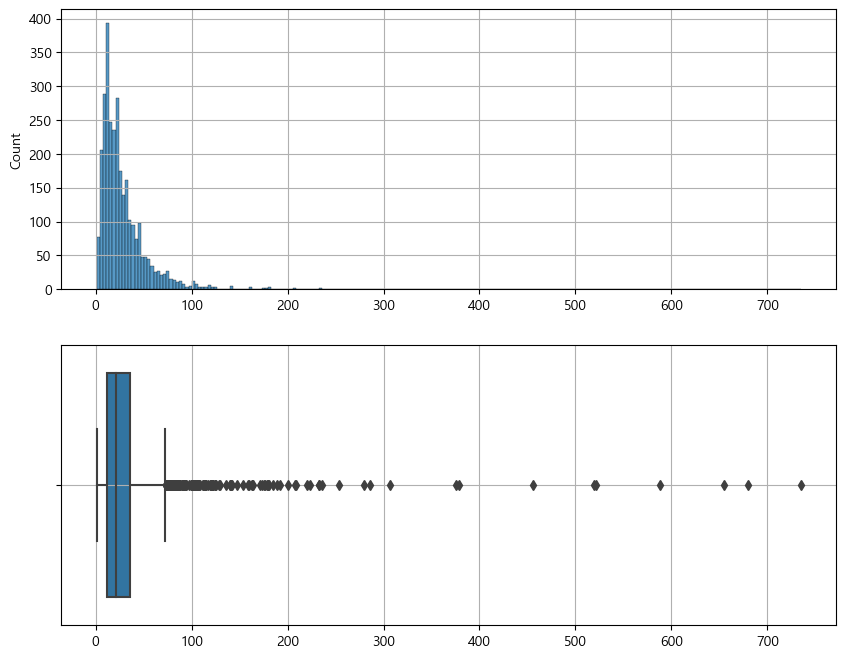

In [44]:
# 문의별 단어의 수 시각화하기
## 데이터 전처리를 통해 data['문의내용']에서 불필요한 단어를 제거하는 데이터 클렌징을 시행하였습니다.
## 나중에 적절한 Padding 값 산출을 위하여 데이터의 문장 길이(단어수)가 어떻게 분포 되어 있는지 클렌징한 데이터를 가지고 시각화 합니다.
## 챠트는 histplot 과 boxplot 두가지를 생성하세요.
## 챠트의 크기는 보기 좋게 자율적으로 설정 합니다.
## 그리드를 표현해 주세요.

plt.figure(figsize=(10,8))

plt.subplot(2, 1, 1)
sns.histplot(cleansing_length)
plt.grid()

plt.subplot(2, 1, 2)
sns.boxplot(x = cleansing_length)
plt.grid()


plt.show()


In [46]:
# 문의별 단어의 수(cleansing_length) 기초통계량 확인하기
## .describe 매서드를 사용하여 cleansing_length 변수의 기초통계량을 확인 합니다.
## 리스트 타입의 변수는 .describe 매서드를 사용할 수 없으니 pd.Series 타입으로 변경하여 확인 합니다.

cleansing_length = pd.Series(cleansing_length)
cleansing_length.describe()


count    3032.0000
mean       30.6781
std        40.1747
min         1.0000
25%        12.0000
50%        21.0000
75%        36.0000
max       735.0000
dtype: float64

In [47]:
# 문의 길이(단어 개수) 상한선 정하기
## 딥러닝 모델에 입력되는 데이터는 그 길이가 같아야 합니다.
## 자연어 처리에 입력의 길이를 똑같이 맞추기 위해 데이터의 앞 또는 뒤에 0을 삽입하는 Padding 기법을 적용합니다.
## 적절한 Padding 값을 도출하기 위해 max_length 변수를 생성하고 cleansing_length 변수의 기초통계량 90% 백분위수 값을 할당해 주세요.
## 특정 백분위수 값을 도출할 때는 .quantile() 매서드를 사용합니다.
## 리스트 타입의 변수는 .quantile() 매서드를 사용할 수 없으니 pd.Series 타입으로 변경하여 사용 합니다.
## .quantile() 매서드의 출력값 데이터 타입은 float 이므로 int 형으로 변경하여 max_length 에 할당해 주세요.

max_length = cleansing_length.quantile(.9)
max_length

58.0

### <span style="color:green;background-color:#fff5b1">[미션3] 단어사전 만들기</span>

AI가 자연어 처리를하기위해 우리가 쓰는 단어를 숫자 형태로 바꾸어 저장한 단어사전을 사용합니다.<br>
단어사전은 모델이 학습에 고려할 단어들을 모아 숫자로 인덱스화 시켜 놓은 것 입니다. <br>
그런데 1:1 문의 데이터에는 쓰임이 거의 없어 성능에 영향을 미치지는 않지만 자원을 소모하는 단어들이 많이 있습니다.<br>
단어사전 생성시 이러한 쓰임이 적은 단어를 제거하여 모델의 효율을 높일 수 있습니다.<br>
단어의 빈도수를 계산하여 쓰임이 많은 단어를 골라 단어사전을 생성해 주세요.<br>
* 단어 모으기
* 전체 단어 빈도수 카운트하기
* 전체 단어 빈도수 및 합계 확인하기
* 희귀 단어 빈도수 및 합계 확인하기
* 전체 단어에서 희귀 단어수가 차지하는 비율 계산하기
* 단어사전 크기 정하기
* 단어사전(단어 인덱스화) 생성하기


In [48]:
# 단어 모으기

## 사용이 많은 중요 단어를 도출하고 단어별 빈도수를 카운트하기위해 데이터에서 단어만 가져와서 모아야 합니다.
## 다중 반복문을 사용하여 data['한글자제거'] 각 행의 단어들만 가져와 word_list 변수를 리스트로 생성하고 단어들을 append 해 주세요.
## 단어를 각 행별로 분리하여 모으지 않고 모든 행을 통합하여 단어를 모아야 합니다.

word_list = []
for i in range(len(data)):
    for j in data['한글자제거'][i]:
        word_list.append(j)

In [49]:
# 전체 단어 빈도수 카운트하기
## Counter 함수를 사용하여 word_list 변수에 포함된 각 단어의 빈도수를 산출하여 word_count에 할당 합니다.
## 할당 후 .most_common 매서드를 사용하여 어떤 단어들이 많이 사용되었는지 확인 합니다.

word_count = Counter(word_list)
word_count.most_common()



[('in', 802),
 ('print', 478),
 ('if', 458),
 ('for', 445),
 ('gt', 439),
 ('어떻게', 428),
 ('df', 383),
 ('train', 308),
 ('궁금합니다', 305),
 ('있을까요', 298),
 ('실습', 285),
 ('다시', 284),
 ('range', 284),
 ('오류가', 283),
 ('있는', 276),
 ('제가', 258),
 ('input', 249),
 ('Python', 248),
 ('test', 240),
 ('어떤', 229),
 ('int', 227),
 ('list', 215),
 ('이렇게', 206),
 ('line', 205),
 ('같은', 202),
 ('경우', 201),
 ('데이터', 198),
 ('lib', 195),
 ('packages', 192),
 ('같이', 190),
 ('File', 190),
 ('import', 189),
 ('모르겠습니다', 183),
 ('해당', 172),
 ('될까요', 171),
 ('data', 169),
 ('문의드립니다', 166),
 ('site', 166),
 ('에러가', 165),
 ('뜹니다', 163),
 ('다른', 161),
 ('self', 161),
 ('split', 161),
 ('not', 155),
 ('len', 155),
 ('코드를', 153),
 ('User', 146),
 ('드립니다', 145),
 ('있습니다', 142),
 ('건가요', 142),
 ('계속', 142),
 ('아니면', 139),
 ('Users', 139),
 ('return', 138),
 ('True', 136),
 ('있나요', 135),
 ('값을', 134),
 ('count', 132),
 ('질문', 130),
 ('total', 130),
 ('to', 130),
 ('대한', 128),
 ('else', 126),
 ('value', 126),
 ('같습니

In [53]:
# 전체 단어 빈도수 및 합계 확인하기
## word_count 변수에서 .values() 매서드를 사용하여 값 만 분리하고 word_frequency에 할당합니다.
## len 함수를 사용하여 total_frequency의 크기(각 값의 개수)를 total_count 변수에 할당 합니다.
## sum 함수 사용하여 total_frequency의 각 값의 총 합을 계산하여 total_frequency_sum 변수에 할당 합니다.

word_frequency = word_count.values()
total_count = len(word_frequency)
total_frequency_sum = sum(word_frequency)
total_count, total_frequency_sum


(23516, 93016)

In [64]:
# 희귀 단어 빈도수 및 합계 확인하기
## word_count 변수에서 .values() 매서드를 사용하여 한번만 사용된 단어만 분리하여 rare_frequency에 할당합니다.
## len 함수를 사용하여 rare_frequency의 크기(각 값의 개수)를 rare_count 변수에 할당 합니다.
## sum 함수 사용하여 rare_frequency의 각 값의 총 합을 계산하여 rare_frequency_sum 변수에 할당 합니다.
rare_frequency = []

for i in word_count:
    if word_count[i] == 1:
        rare_frequency.append(i)

rare_count = len(rare_frequency)
rare_count

14417

In [66]:
# 전체 단어에서 희귀 단어수가 차지하는 비율 계산하기
## 전체 단어 개수에서 희귀 단어개 수가 차지하는 비율을 계산해서 rare_count_percent 할당 합니다.
## 전체 단어의 사용 빈도수 합에서 희귀 단어의 사용 빈도수 합이차지하는 비율을 계산해서 rare_frequency_percent 할당 합니다.
## 희귀 단어가 전체 단어에서 얼만큼의 비중이 있는지 각 값들을 출력 합니다.

rare_count_percent = rare_count / total_count
rare_frequency_percent = rare_count / total_frequency_sum

print("데이터의 전체 단어 수: ", total_count)
print("데이터 내 전체 희귀 단어수: ", rare_count)
print("\n")
print("데이터의 전체 단어의 빈도 수 합: ", total_frequency_sum)
print("데이터 내 전체 희귀 단어의 빈도 수 합: ", rare_count)
print("전체 단어에서 희귀 단어가 차지하는 비율: ", rare_frequency_percent)

데이터의 전체 단어 수:  23516
데이터 내 전체 희귀 단어수:  14417


데이터의 전체 단어의 빈도 수 합:  93016
데이터 내 전체 희귀 단어의 빈도 수 합:  14417
전체 단어에서 희귀 단어가 차지하는 비율:  0.1549948395974886


In [67]:
# 단어사전 크기 정하기
## 전체 단어 수에서 희귀단어 수가 차지하는 비율은 매우 높은데 비해 사용 빈도수는 저조 합니다.
## 희귀 단어들이 모델 학습에 포함되지 않도록 단어사전의 크기를 설정하여 제한 합니다.
## 단어사전의 크기 = 전체 단어 수 - 희귀 단어수

dic_size = total_count - rare_count
dic_size

9099

In [68]:
# 단어사전(단어 인덱스화) 생성하기
## 단어사전을 생성하기 위해서 설정한 단어사전의 크기에 맞게 쓰임이 많은 단어 부터 인덱스를 부합니다.
## keras Tokenizer 함수를 이용하여 단어에 인덱스를 부여해 단어사전을 생성해 주세요.(토크나이즈)
## 단어사전을 생성 할 때, 사전에 불필요한 단어까지 포함되지 않도록 위에서 설정한 vocab_size 이용하여 tokenizer 파라미터를 설정해서 초기화 하세요.
## [TIP] keras tokenizer 참고 사이트: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
data['토큰화'] = ''
tokenizer = Tokenizer(num_words=dic_size)
tokenizer.fit_on_texts(data['한글자제거'])
data['토큰화'] = tokenizer.texts_to_sequences(data['한글자제거'])
data

,문의내용,문의유형,특수문자제거,단어분리,불용어제거,한글자제거,토큰화
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",코드2,inplace True 를 사용하는 기준이 존재하는 것인지 아니면 함수나 메소드에 ...,"[inplace, True, 를, 사용하는, 기준이, 존재하는, 것인지, 아니면, ...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나...","[285, 53, 367, 884, 1285, 193, 54, 5588, 5589,..."
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,시스템 운영,참조파일 에 대한 yolo부분 답안 파일이 올라오지 않은 것 같습니다,"[참조파일, 에, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 같습니다]","[8907, 64, 8908, 1286, 180, 8909, 286, 69]"
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",시스템 운영,AICE 시험 관련하여 이렇게 대 로 질문하는게 맞나요 맞다면 질문드립니다 구글링이...,"[AICE, 시험, 관련하여, 이렇게, 대, 로, 질문하는게, 맞나요, 맞다면, 질...","[AICE, 시험, 관련하여, 이렇게, 대, 질문하는게, 맞나요, 맞다면, 질문드립...","[AICE, 시험, 관련하여, 이렇게, 질문하는게, 맞나요, 맞다면, 질문드립니다,...","[668, 517, 787, 25, 8910, 142, 1186, 89, 3192,..."
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,코드1,예제는 잘 작동한 것 같은데 채점하니 케이스 만 성공하고 나머지가 fail이 떠 실...,"[예제는, 잘, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가...","[예제는, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가, f...","[예제는, 작동한, 같은데, 채점하니, 케이스, 성공하고, 나머지가, fail이, ...","[8916, 8917, 72, 8918, 194, 5596, 4106, 395, 5..."
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,이론,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,"[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[8919, 1976, 5598, 8920, 1401, 1287, 8921, 892..."
...,...,...,...,...,...,...,...
3027,"증권사의 디지털화에 대한 솔루션을 진행할 때 비용, 수익구조에 대한 이해가 부족한 ...",이론,증권사의 디지털화에 대한 솔루션을 진행할 때 비용 수익구조에 대한 이해가 부족한 것...,"[증권사의, 디지털화에, 대한, 솔루션을, 진행할, 때, 비용, 수익구조에, 대한,...","[증권사의, 디지털화에, 대한, 솔루션을, 진행할, 때, 비용, 수익구조에, 대한,...","[증권사의, 디지털화에, 대한, 솔루션을, 진행할, 비용, 수익구조에, 대한, 이해...","[64, 1287, 1259, 5265, 64, 110, 1723, 69, 249,..."
3028,용어가 많이 헷갈리는데 단변량과 이변량의 정의가 뭔지 궁금합니다!,이론,용어가 많이 헷갈리는데 단변량과 이변량의 정의가 뭔지 궁금합니다,"[용어가, 많이, 헷갈리는데, 단변량과, 이변량의, 정의가, 뭔지, 궁금합니다]","[용어가, 많이, 헷갈리는데, 단변량과, 이변량의, 정의가, 뭔지, 궁금합니다]","[용어가, 많이, 헷갈리는데, 단변량과, 이변량의, 정의가, 뭔지, 궁금합니다]","[4648, 389, 4185, 8011, 2505, 1220, 10]"
3029,안녕하세ㅐ요 . plt.axhline(1-titanic['Survived'].m...,코드2,안녕하세 요 pltaxhline titanic Survived mean color ...,"[안녕하세, 요, pltaxhline, titanic, Survived, mean,...","[안녕하세, pltaxhline, titanic, Survived, mean, co...","[안녕하세, pltaxhline, titanic, Survived, mean, co...","[2597, 408, 1128, 294, 770, 18, 110, 1445, 272..."
3030,https://drive.google.com/file/d/1nfTT7ezFZqUBu...,코드2,https drivegooglecom file d nfTT ezFZqUBuY mvw...,"[https, drivegooglecom, file, d, nfTT, ezFZqUB...","[https, drivegooglecom, file, d, nfTT, ezFZqUB...","[https, drivegooglecom, file, nfTT, ezFZqUBuY,...","[184, 2462, 19, 2907, 2908, 4364, 1263, 2149, ..."


### <span style="color:green;background-color:#fff5b1">[미션4] 모델 학습 데이터 생성</span>

모델의 학습을 위하여 학습 데이터를 생성해야 합니다.<br>
모델의 Y(target) 데이터는 data['문의유형'] 데이터 이고, X(Feature)는 1:1 문장을 토큰화 한 data['토큰화'] 데이터 입니다.
그러나 현재의 형태로는 1:1 문의 자동분류 모델을 학습 시킬수 없습니다.
모델을 학습 시킬 수 있도록 데이터를 전처리 해주세요.
* data['문의유형'] 데이터 변경하기
* Y(target) 데이터 분리하기
* X(Feature) 데이터 분리 및 padding 적용하기
* 학습 데이터 분리하기

In [69]:
# data['문의유형'] 데이터 변경하기
## 코드 관련 문의와 코드 이외 문의의 카테고리를 나눠 주세요.
## data['문의유형'] 값 중 '코드1', '코드2'는 1로, 그 외 값들은 0으로 변경해 주세요.
## [TIP] 변경할 값은 type_dict 변수의 딕셔너리를 참조 하세요.


type_dict = {
    '코드1': 1,
    '코드2': 1,
    '웹': 0,
    '이론': 0,
    '시스템 운영': 0,
    '원격': 0
}

data['문의유형'] = data['문의유형'].map(type_dict)
data.head()

,문의내용,문의유형,특수문자제거,단어분리,불용어제거,한글자제거,토큰화
0,"inplace= True 를 사용하는 기준이 존재하는 것인지, 아니면 함수나 메소드...",1,inplace True 를 사용하는 기준이 존재하는 것인지 아니면 함수나 메소드에 ...,"[inplace, True, 를, 사용하는, 기준이, 존재하는, 것인지, 아니면, ...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나...","[inplace, True, 사용하는, 기준이, 존재하는, 것인지, 아니면, 함수나...","[285, 53, 367, 884, 1285, 193, 54, 5588, 5589,..."
1,참조파일2에 대한 (yolo부분) 답안 파일이 올라오지 않은 것 같습니다!,0,참조파일 에 대한 yolo부분 답안 파일이 올라오지 않은 것 같습니다,"[참조파일, 에, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 것, 같습니다]","[참조파일, 대한, yolo부분, 답안, 파일이, 올라오지, 않은, 같습니다]","[8907, 64, 8908, 1286, 180, 8909, 286, 69]"
2,"AICE 시험 관련하여 이렇게 1대1로 질문하는게 맞나요..? 맞다면, 질문드립니다...",0,AICE 시험 관련하여 이렇게 대 로 질문하는게 맞나요 맞다면 질문드립니다 구글링이...,"[AICE, 시험, 관련하여, 이렇게, 대, 로, 질문하는게, 맞나요, 맞다면, 질...","[AICE, 시험, 관련하여, 이렇게, 대, 질문하는게, 맞나요, 맞다면, 질문드립...","[AICE, 시험, 관련하여, 이렇게, 질문하는게, 맞나요, 맞다면, 질문드립니다,...","[668, 517, 787, 25, 8910, 142, 1186, 89, 3192,..."
3,예제는 잘 작동한 것 같은데 채점하니 케이스 1만 성공하고 나머지가 fail이 떠 ...,1,예제는 잘 작동한 것 같은데 채점하니 케이스 만 성공하고 나머지가 fail이 떠 실...,"[예제는, 잘, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가...","[예제는, 작동한, 것, 같은데, 채점하니, 케이스, 만, 성공하고, 나머지가, f...","[예제는, 작동한, 같은데, 채점하니, 케이스, 성공하고, 나머지가, fail이, ...","[8916, 8917, 72, 8918, 194, 5596, 4106, 395, 5..."
4,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,0,제주관광공사를 대상으로 관광지 순환 버스 솔루션을 도입하여 운전을 못하는 관광객 유...,"[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[제주관광공사를, 대상으로, 관광지, 순환, 버스, 솔루션을, 도입하여, 운전을, ...","[8919, 1976, 5598, 8920, 1401, 1287, 8921, 892..."


In [71]:
# Y(target) 데이터 분리하기
## 모델 학습에 Y(target) 으로 사용할 data['문의유형'] 열을 분리하여 y_data 변수에 할당 합니다.
y_data = data['문의유형']
y_data

0       1
1       0
2       0
3       1
4       0
       ..
3027    0
3028    0
3029    1
3030    1
3031    0
Name: 문의유형, Length: 3032, dtype: int64

In [128]:
# X(Feature) 데이터 분리 및 padding 적용하기
## 모델을 학습시키기 위해서 모든 X(Feature) 데이터의 길이는 같아야 합니다.
## 즉, 모델 학습에 사용할 data['토큰화'] 의 길이가 행마다 다 같아야 합니다.
## pad_sequences 함수를 사용하여 모든 행의 길이를 맞추어 x_data 변수에 할당해 주세요.
## 이때 데이터의 길이 제한은 전체 문장의 90%가 포함될 수 있도록 max_length 변수의 값으로 설정해 주세요.

x_data = pad_sequences(data['토큰화'], maxlen=dic_size)
x_data


array([[   0,    0,    0, ..., 5588, 5590,   10],
       [   0,    0,    0, ..., 8909,  286,   69],
       [   0,    0,    0, ...,  640, 2669,   28],
       ...,
       [   0,    0,    0, ..., 5208,  650,   37],
       [   0,    0,    0, ..., 1195,   93,   11],
       [   0,    0,    0, ...,  218, 1150,   89]])

In [129]:
# 학습 데이터 분리하기
## 모델을 학습시킬 데이터를 train_test_split 매서드를 사용하여 학습 데이터 7, 검증 데이터로 3 비율로 나누어 줍니다.

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3)


### <span style="color:green;background-color:#fff5b1">[미션5] 모델 생성하기</span>

1:1 문의 자동 분류기는 입력된 자연어를 코드/일반 문의로 나눌 수 있는 2진 분류기 입니다.
2진 분류 자연어 처리에 알맞게 딥러닝 Layer 를 설계하고, 2진 분류에 맞는 활성화 함수를 지정하여 최고의 분류 성능을 도출해 주세요.


* 딥러닝 모델 생성하기
* 모델 학습하기
* 결과 예측하기
* 예측 결과 변경하기
* 이진분류 모델 평가하기

In [130]:
# 딥러닝 모델 생성하기
## 딥러닝 모델 생성을 위해 keras 라이브러리를 사용합니다.
## 입력층 shape 는 미리 설정한 max_length 으로 지정 합니다.
## Embedding 층을 추가하여 입력 데이터를 벡터화 해주세요.
## Embedding 층 입력 차원은 vocab_size 변수 값과 같습니다.
## 히든레이어 층은 최고의 성능이 나올수 있도록 자유롭게 작성 합니다.
## 출력층의 노드는 분류 하려는 Class 개수와 동일합니다.
## 활성화 함수는 이진 분류에 알맞은 함수를 사용합니다.
## 모델 compile 시 사용할 손실 함수는 이진 분류에 알맞은 함수를 사용합니다.
## 모델의 Layer 설계는 Sequential 함수를 사용해서 생성해도 됩니다.
max_length = max_length.astype('int')

from keras.backend import clear_session

clear_session()

X = tf.keras.Input(shape=[dic_size])
H = tf.keras.layers.Embedding(dic_size, 128)(X)
H = tf.keras.layers.SimpleRNN(32)(H)
Y = tf.keras.layers.Dense(1, activation="sigmoid")(H)

model = tf.keras.Model(X, Y)
model.compile(loss="binary_crossentropy", metrics="accuracy")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9099)]            0         
                                                                 
 embedding (Embedding)       (None, 9099, 128)         1164672   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1169857 (4.46 MB)
Trainable params: 1169857 (4.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
# 모델 학습하기
## 생성한 모델에 x_train, y_train를 적용하여 모델을 학습 시킵니다.
## epochs, batch_size, validation_split 은 최고의 성능이 나올 수 있도록 자유롭게 작성 합니다.

model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
14/14 [==============================] - 177s 13s/step - loss: 0.6511 - accuracy: 0.6264 - val_loss: 0.5918 - val_accuracy: 0.7012
Epoch 2/10
14/14 [==============================] - 152s 11s/step - loss: 0.5144 - accuracy: 0.7690 - val_loss: 0.5404 - val_accuracy: 0.7506
Epoch 3/10
14/14 [==============================] - 116s 8s/step - loss: 0.3801 - accuracy: 0.8733 - val_loss: 0.5348 - val_accuracy: 0.7718
Epoch 4/10
14/14 [==============================] - 124s 9s/step - loss: 0.2714 - accuracy: 0.9411 - val_loss: 0.4964 - val_accuracy: 0.8094
Epoch 5/10
14/14 [==============================] - 198s 15s/step - loss: 0.3538 - accuracy: 0.8580 - val_loss: 0.6172 - val_accuracy: 0.6729
Epoch 6/10
14/14 [==============================] - 216s 15s/step - loss: 0.5056 - accuracy: 0.7448 - val_loss: 1.0045 - val_accuracy: 0.4282
Epoch 7/10
14/14 [==============================] - 202s 14s/step - loss: 0.3499 - accuracy: 0.8433 - val_loss: 0.6098 - val_accuracy: 0.6541
Epoch 8/

In [132]:
# 결과 예측하기
## 검증용 x_val 사용해서 결과를 예측 합니다.

y_pred = model.predict(x_val)

29/29 [==============================] - 11s 367ms/step


In [133]:
# 예측 결과 변경하기
## 예측 된 결과는 0~1 사이에 실수 값으로 출력 됩니다.
## 검증 데이터(y_val)와 비교 할 수 있도록 정수 형태로 변경 합니다.
## 반올림을 적용하여 예측값이 0.5 이상이면 1, 미만이면 0 으로 변경해 주세요.

pred = np.where(y_pred>=0.5, 1, 0)

In [134]:
# 이진분류 모델 평가하기
## y_val 검증 데이터를 사용하여 모델의 성능을 평가 합니다.
## 평가는 confusion_matrix, classification_report 를 사용하여 평가 합니다.

print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       526
           1       0.57      0.64      0.61       384

    accuracy                           0.65       910
   macro avg       0.64      0.65      0.64       910
weighted avg       0.66      0.65      0.65       910



### <span style="color:green;background-color:#fff5b1">[미션6] 분류 모델 고도화</span>

- 모델의 고도화 위해 데이터 클렌징 방법 변경, 다른 모델 사용, 인공신경망 레이어 조정 등 다양한 기법을 사용하여 1:1 문의 자동 분류 모델의 정확도를 개선해 주세요.<br>
- 우리조의 모델 설계 내용을 정리하여 최고 성능 도출 방법을 소개해 주세요.<br>
<br><br><br><br>

In [135]:
X = tf.keras.Input(shape=[dic_size])
H = tf.keras.layers.Embedding(dic_size, 128)(X)
H = tf.keras.layers.SimpleRNN(32)(H)
H = tf.keras.layers.Dense(16, activation = 'relu')(H)
Y = tf.keras.layers.Dense(1, activation="sigmoid")(H)

model = tf.keras.Model(X, Y)

model.compile(loss="binary_crossentropy", metrics="accuracy")
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

y_pred = model.predict(x_val)
pred = np.where(y_pred>=0.5, 1, 0)
print(classification_report(y_val, pred))

Epoch 1/10
14/14 [==============================] - 121s 9s/step - loss: 0.6513 - accuracy: 0.6358 - val_loss: 0.6042 - val_accuracy: 0.7106
Epoch 2/10
14/14 [==============================] - 185s 14s/step - loss: 0.5116 - accuracy: 0.7666 - val_loss: 0.5566 - val_accuracy: 0.7365
Epoch 3/10
14/14 [==============================] - 223s 16s/step - loss: 0.3899 - accuracy: 0.8774 - val_loss: 0.4618 - val_accuracy: 0.8118
Epoch 4/10
14/14 [==============================] - 116s 8s/step - loss: 0.2783 - accuracy: 0.9210 - val_loss: 0.4007 - val_accuracy: 0.8353
Epoch 5/10
14/14 [==============================] - 105s 8s/step - loss: 0.3904 - accuracy: 0.8603 - val_loss: 0.7608 - val_accuracy: 0.5812
Epoch 6/10
14/14 [==============================] - 107s 8s/step - loss: 0.3252 - accuracy: 0.8680 - val_loss: 0.4415 - val_accuracy: 0.7929
Epoch 7/10
14/14 [==============================] - 113s 8s/step - loss: 0.1524 - accuracy: 0.9717 - val_loss: 0.4077 - val_accuracy: 0.8165
Epoch 8/10


----------
----------

### <span style="color:red;background-color:#fff5b1"><도전미션> 테스트 데이터를 활용한 모델 성능 뽐내기 </span>

* QnA_test_data.csv 파일에는 추가 문의에 대한 데이터가 있습니다.
* QnA_test_data.csv 파일 불러와 문의에 대한 분류 결과값을 예측해 봅니다.
* QnA_test_data.csv 데이터셋은 전처리가 되어 있지 않습니다.
* 우리조 만의 데이터 클렌징 방법과 모델링 기법을 활용하여 Test 데이터 에서의 최고의 성능을 도출해 주세요.
* <도전미션>은 아래의 가이드 코드와 셀을 무시하고 자유롭게 코드를 작성하세요.


----------
----------


----------


# 수고 많으셨습니다

----------